In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from ase.io.trajectory import Trajectory

from abtem import __version__
print('AbTEM version:',__version__)
from abtem import Potential, PlaneWave, CTF
from abtem.temperature import MDFrozenPhonons
from abtem.noise import poisson_noise
from abtem.mtf import MTF
from abtem.transfer import scherzer_defocus

from skimage.filters import gaussian

AbTEM version: 1.0.0beta24


In [2]:
itraj = Trajectory('trajectory_data/initial.traj')
fptraj = Trajectory('trajectory_data/fp-hot.traj')
mdtraj = Trajectory('trajectory_data/md-hot.traj')

iconfig = itraj[0]
fpconfigs = fptraj[::10]
mdconfigs = mdtraj[len(fptraj)+1::10]

print(len(fpconfigs),len(mdconfigs))
fp_phonons = MDFrozenPhonons(fpconfigs)
md_phonons = MDFrozenPhonons(mdconfigs)

N = 1000
sampling = 0.05
ipotential = Potential(iconfig,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')
fppotential = Potential(fp_phonons,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')
mdpotential = Potential(md_phonons,
              sampling=sampling,
              gpts=(N,N),
              parametrization='kirkland',
              projection='infinite')

250 250


In [3]:
wave = PlaneWave(energy=50e3)

In [4]:
iexitwave = wave.multislice(ipotential)

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

In [5]:
fpexitwave = wave.multislice(fppotential)

TDS:   0%|          | 0/250 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

In [6]:
mdexitwave = wave.multislice(mdpotential)

TDS:   0%|          | 0/250 [00:00<?, ?it/s]

Multislice:   0%|          | 0/31 [00:00<?, ?it/s]

Potential:   0%|          | 0/31 [00:00<?, ?it/s]

Scherzer Defocus: <function scherzer_defocus at 0x7f111aa8b670> Å


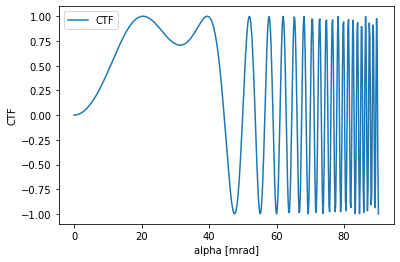

In [7]:
# See coefficients here
# https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html
Cs = 8300*10 # Spherical abberation in Å
ctf = CTF(
    Cs=Cs,
    energy = wave.energy
)
ctf.defocus = scherzer_defocus(Cs, wave.energy) # Optimal defocus based on Cs and wavelength
print('Scherzer Defocus: {} Å'.format(scherzer_defocus))

ctf.show(90)
plt.show()

In [8]:
iimagewave = iexitwave.apply_ctf(ctf)
fpimagewave = fpexitwave.apply_ctf(ctf)
mdimagewave = mdexitwave.apply_ctf(ctf)

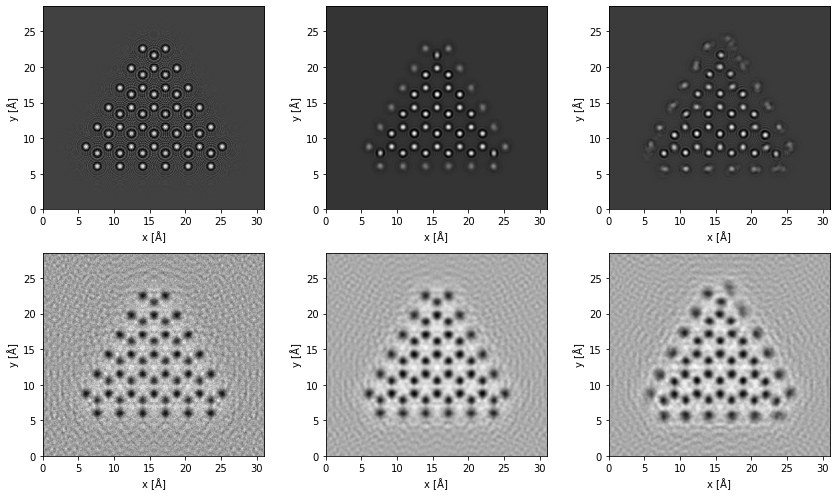

In [9]:
fig, ax = plt.subplots(figsize=(12.0,7.0),nrows=2,ncols=3)
iexitwave.intensity()[0].show(ax=ax[0,0])
fpexitwave.intensity().mean(0).show(ax=ax[0,1])
mdexitwave.intensity().mean(0).show(ax=ax[0,2])
iimagewave.intensity()[0].show(ax=ax[1,0])
fpimagewave.intensity().mean(0).show(ax=ax[1,1])
mdimagewave.intensity().mean(0).show(ax=ax[1,2])

plt.tight_layout()
plt.show()

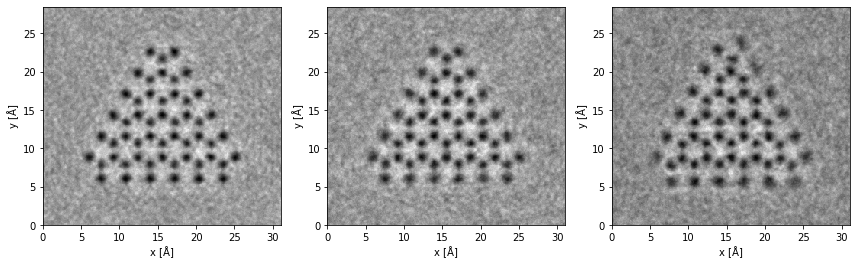

In [10]:
resample = 0.1    # Angstrom/pixel for detector resolution
dose = 1*10**3      # electrons/Angstrom squared for noise
mtf_parameters = {
  'c0': 1.0,
  'c1': 0.05,
  'c2': 0.45,
  'c3': 2.5
}
blur = 0.5

fig = plt.figure(figsize=(12,12))
for i,measurement_raw in enumerate([ iimagewave.intensity(), fpimagewave.intensity().mean(0), mdimagewave.intensity().mean(0) ]):
    # Add noise to image
    measurement_noise = poisson_noise(measurement_raw, dose)

    # Apply MTF
    mtf = MTF(**mtf_parameters)
    measurement_MTF = mtf(measurement_noise)

    # Add gaussian blur
    measurement = measurement_MTF.copy()
    array = measurement.array
    measurement.array[:] = gaussian(array,blur)
    
    # Resample to match experimental
    measurement = measurement.squeeze() # Removes 0 dimension (be careful when doing frozen phonon)
    measurement = measurement.interpolate(resample)
    
    ax = fig.add_subplot(1,3,i+1)
    measurement.show(ax=ax)
plt.tight_layout()
plt.show()